In [1]:
from astropy.table import Table, join
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from matplotlib import cm
from matplotlib.lines import Line2D
import matplotlib.lines as mlines


import time
from numpy.random import default_rng

import healpy as hp
from healpy.newvisufunc import projview, newprojplot
import pandas as pd

import astropy.cosmology
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import Table

import sys
sys.path.insert(0,'../code')
%load_ext autoreload
%autoreload 2
import utils
import generate_random
import correlations
import masks
import maps
import animate

# Parameter setting

Plot formatting

In [2]:
matplotlib.rcParams['ytick.labelsize'] = 18
matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['axes.labelsize'] = 22
matplotlib.rcParams['axes.titlesize'] = 24
matplotlib.rcParams['legend.fontsize'] = 18

matplotlib.rc('text', usetex=True)

Saving

In [3]:
plot_dir = '../plots/2023-03-29_figures'
save = True

Names

In [4]:
name_catalog = '\emph{{Gaia}} Cosmological Quasar Catalog'
abbrv_catalog = 'GaiaQ'

name_gpurer = '\emph{{Gaia}} Purer Sample'
abbrv_gpurer = '\emph{{Gaia}} Purer'

Plotting variables

In [270]:
cmap_anim = utils.shiftedColorMap(matplotlib.cm.plasma_r, start=0.2, midpoint=0.6, stop=1.0, name='plasma_shift')
cmap_map = 'plasma'
cmap_blues = utils.shiftedColorMap(matplotlib.cm.Blues, start=0.2, midpoint=0.6, stop=1.0, name='Blues_shifted')
cmap_hist = 'inferno_r'

color_gaia = 'purple'

ValueError: A colormap named "Blues_shifted" is already registered.

Functions

In [6]:
def get_ndens_map(ras, decs, NSIDE=64):
    map_nqso, _ = maps.get_map(NSIDE, ras, decs, null_val=0)
    map_ndens = map_nqso/area_per_pixel
    map_ndens_masked = hp.ma(map_ndens)
    map_ndens_masked.mask = map_ndens==0
    return map_ndens_masked

Map settings

In [7]:
NSIDE = 64
area_per_pixel = hp.nside2pixarea(NSIDE, degrees=True)
print(f"Area per pixel: {area_per_pixel:.3f} deg")

Area per pixel: 0.839 deg


Other prelims

In [8]:
G_hi = 20.5
G_lo = 20.0

In [9]:
rng = np.random.default_rng(seed=42)

# Load datasets

### Gaia

TODO: run gaia_candidates_plus_info in local make_data_tables to add wise data to plus file. then rewrite and rerun superset in make_data_tables cuz dont need wise info there

In [322]:
fn_gall = '../data/gaia_candidates_plus.fits.gz'
tab_gall = utils.load_table(fn_gall)
print(len(tab_gall))

6649162


In [11]:
fn_gpurer_ids = '../data/gaia_purer_sourceids.fits'
tab_gpurer_ids = utils.load_table(fn_gpurer_ids)
tab_gpurer = join(tab_gall, tab_gpurer_ids, keys='source_id', join_type='inner', metadata_conflicts='silent')
print(len(tab_gpurer))

1942825


In [12]:
fn_gsup = '../data/gaia_candidates_superset.fits'
tab_gsup = utils.load_table(fn_gsup)
print(len(tab_gsup))

1518782


In [13]:
fn_gclean = '../data/gaia_candidates_clean.fits'
tab_gclean = utils.load_table(fn_gclean)
print(len(tab_gclean))

1442077


In [345]:
fn_gcatlo = f'../data/gaiaQ_G{G_lo}.fits'
tab_gcatlo = utils.load_table(fn_gcatlo)
print(len(tab_gcatlo))

762347


In [346]:
fn_gcathi = f'../data/gaiaQ_G{G_hi}.fits'
tab_gcathi = utils.load_table(fn_gcathi)
print(len(tab_gcathi))

1309315


### SDSS

These are SDSS objects that have (any) Gaia source matches. There is unWISE data where available, but the below catalogs are not limited to unWISE matches.

In [16]:
tab_squasars = utils.load_table(f'../data/quasars_sdss_xgaia_xunwise_good_nodup.fits')
print(f"Number of SDSS quasars: {len(tab_squasars)}")
print(f"Number with unWISE info:", np.sum(np.isfinite(tab_squasars['mag_w1_vg']) & ~tab_squasars.mask['mag_w1_vg']))

Number of SDSS quasars: 379698
Number with unWISE info: 350070


In [17]:
tab_sstars = utils.load_table(f'../data/stars_sdss_xgaia_xunwise_good_nodup.fits')
print(f"Number of SDSS stars: {len(tab_sstars)}")
print(f"Number with unWISE info:", np.sum(np.isfinite(tab_sstars['mag_w1_vg']) & ~tab_sstars.mask['mag_w1_vg']))

Number of SDSS stars: 683221
Number with unWISE info: 482080


In [18]:
tab_sgals = utils.load_table(f'../data/galaxies_sdss_xgaia_xunwise_good_nodup.fits')
print(f"Number of SDSS galaxies: {len(tab_sgals)}")
print(f"Number with unWISE info:", np.sum(np.isfinite(tab_sgals['mag_w1_vg']) & ~tab_sgals.mask['mag_w1_vg']))

Number of SDSS galaxies: 717059
Number with unWISE info: 600897


Only objects in superset (gaia qso candidates with unWISE data and QSOC redshifts and G lim)

In [19]:
fn_labeled_sup = '../data/labeled_superset.fits'
tab_labeled_sup = utils.load_table(fn_labeled_sup)
print(f"Number of labeled Gaia quasar candidates for training/validation: {len(tab_labeled_sup)}")

Number of labeled Gaia quasar candidates for training/validation: 249714


# Figures

### Purer map

TODO: should i limit to having QSOC redshifts here? (now just do G lim)

TODO: healpy / matplotlib error with show_tickmarkers=True

In [78]:
map_gpurer = get_ndens_map(tab_gpurer['ra'], tab_gpurer['dec'], NSIDE=NSIDE)

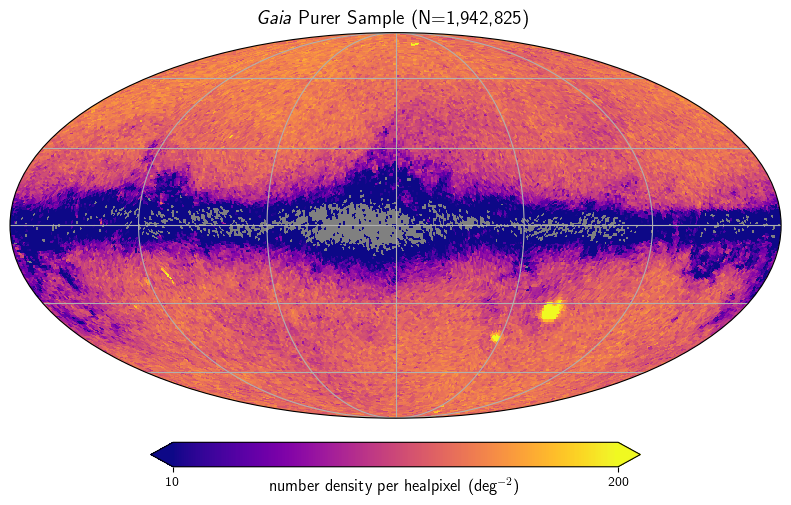

In [79]:
projview(map_gpurer, title=rf"{name_gpurer} (N={len(tab_gpurer):,})",
            unit=r"number density per healpixel (deg$^{-2}$)", cmap=cmap_map, coord=['C', 'G'], 
            min=10, max=200, norm='log', graticule=True,
            #show_tickmarkers=True
        )

fn = f'{plot_dir}/gpurer_2d.png'
if save:
    plt.savefig(fn, bbox_inches='tight')

### Fractional matrix

TODO: use sdss DR16 instead of current sdss. check if then have outer join of that with gaia source ids, or make

In [22]:
tab_squasars_all = utils.load_table('../data/sdss_quasars_specobj.csv', format='csv')
tab_squasars_xgaia = utils.load_table('../data/quasars_sdss_xgaia.csv', format='csv')
print(tab_squasars_all.columns)
print(tab_squasars_xgaia.columns)

<TableColumns names=('specObjID','ra','dec')>
<TableColumns names=('ra','dec','source_id','ra_sdss','dec_sdss','objid','z','phot_g_mean_mag','phot_bp_mean_mag','phot_rp_mean_mag','phot_bp_n_obs','phot_rp_n_obs')>


In [23]:
# tab_squasars_xgaia.keep_columns()
# tab_squasars_xgaia_all = join(tab_squasars_all, tab_squasars_xgaia, keys='specObjID')

Hum looks like i didnt save the specObjID.... will need to figure out

In [24]:
tab_gqsoc = tab_gall[np.isfinite(tab_gall['redshift_qsoc'])]
print(len(tab_gqsoc))

6375063


In [315]:
#tabs_forwise = [tab_gall, tab_squasars_xgaia]

In [320]:
tabs = [tab_gall, tab_gqsoc, tab_gpurer, tab_gsup, tab_gclean, tab_squasars_xgaia]
tab_names = ['\emph{Gaia} quasar candidates', 
             '\emph{Gaia} quasar candidates\nwith redshift estimates', 
             '\emph{Gaia} purer', 
             'GaiaQ superset', 
             'GaiaQ clean', 
             r'SDSS Quasars $\times$ Gaia',
             'unWISE']
N_tabs = len(tabs)
N_rows = len(tab_names)

frac_matrix = np.empty((N_tabs, N_rows))
for i in range(N_tabs):
    for j in range(N_rows):
        print(tab_names[i], tab_names[j])
        if tab_names[j]=='unWISE':
            i_iinj = np.isfinite(tabs[i]['mag_w1_vg']) & ~tabs[i].mask['mag_w1_vg'] & \
                     np.isfinite(tabs[i]['mag_w2_vg']) & ~tabs[i].mask['mag_w2_vg']
        else:
            i_iinj = np.isin(tabs[i]['source_id'], tabs[j]['source_id'])
        frac_matrix[i,j] = np.sum(i_iinj)/len(i_iinj)
        
frac_matrix = frac_matrix.T

\emph{Gaia} quasar candidates \emph{Gaia} quasar candidates
\emph{Gaia} quasar candidates \emph{Gaia} quasar candidates
with redshift estimates
\emph{Gaia} quasar candidates \emph{Gaia} purer
\emph{Gaia} quasar candidates GaiaQ superset
\emph{Gaia} quasar candidates GaiaQ clean
\emph{Gaia} quasar candidates SDSS Quasars $\times$ Gaia
\emph{Gaia} quasar candidates unWISE


KeyError: 'mag_w1_vg'

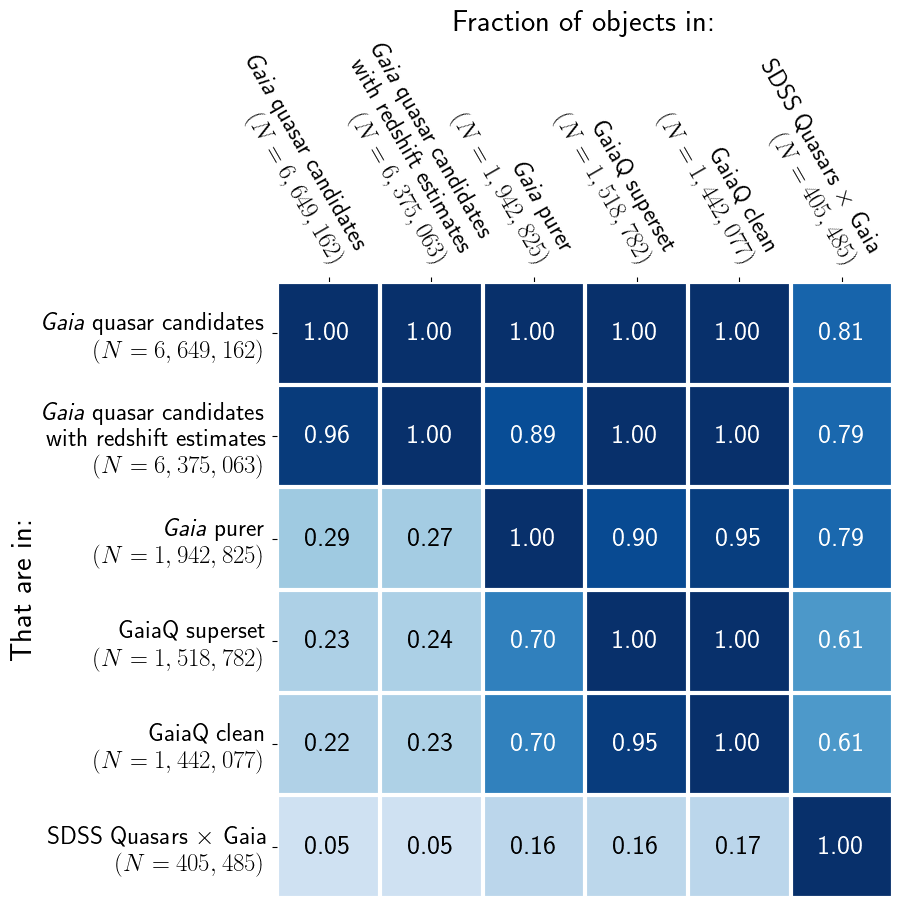

In [26]:
plt.figure(figsize=(8,8))
ax = plt.gca()
im = ax.imshow(frac_matrix, cmap=cmap_blues)

# Show all ticks and label them with the respective list entries
labels_withN = [f'{tab_names[i]}\n(N={len(tabs[i]):,})' for i in range(N_tabs)]
ax.set_xticks(np.arange(len(tab_names)), labels=labels_withN)
ax.set_yticks(np.arange(len(tab_names)), labels=labels_withN)
ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=-60, ha="right",
             rotation_mode="anchor")

ax.spines[:].set_visible(False)
ax.set_xticks(np.arange(frac_matrix.shape[1]+1)-.5, minor=True)
ax.set_yticks(np.arange(frac_matrix.shape[0]+1)-.5, minor=True)
ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
ax.tick_params(which="minor", bottom=False, left=False)

# Loop over data dimensions and create text annotations.
for i in range(len(tab_names)):
    for j in range(len(tab_names)):
        color = 'w' if frac_matrix[i, j]>0.5 else 'k'
        text = ax.text(j, i, f"{frac_matrix[i, j]:.2f}",
                       ha="center", va="center", color=color, fontsize=20)
        
plt.title("Fraction of objects in:", fontsize=22)
plt.ylabel("That are in:", fontsize=22)

fn = f'{plot_dir}/frac_matrix.png'
if save:
    plt.savefig(fn, bbox_inches='tight')

TODO: make non rectangular so can include WISE etc 

### Decontamination

In [470]:
def plot_cuts(ax, cuts, cut_names, x_color_name, y_color_name, xlim, ylim,
              x_orders=None, y_orders=None, zorder=100):

    i_x, i_y = None, None
    if x_color_name in cut_names:
        i_x = cut_names.index(x_color_name)
    if y_color_name in cut_names:
        i_y = cut_names.index(y_color_name)
    
    color = 'k'
    cuts_toplot = []
    x_orders_toplot = []
    y_orders_toplot = []
    for i, cut_full in enumerate(cuts): 
        if i_x is None and i_y is None:
            continue
            
        intercept = cut_full[cut_names.index('intercept')]
        cut = [cut_full[i_x], cut_full[i_y], intercept]

        if i_y is None:
            cut[1] = 0
        if i_x is None:
            cut[0] = 0
        if cut[0]==0 and cut[1]==0:
            continue
            
        cuts_toplot.append(cut)
        x_orders_toplot.append(x_orders[i])
        y_orders_toplot.append(y_orders[i])
          
    xlims = [list(xlim) for _ in range(len(cuts_toplot))]
    ylims = [list(ylim) for _ in range(len(cuts_toplot))]

    # this is ugly but i think need some user input to determine order??
    for ix in range(len(x_orders_toplot)-1):
        i, j = x_orders_toplot.index(ix), x_orders_toplot.index(ix+1)
        cut_0, cut_1 = cuts_toplot[i], cuts_toplot[j]
        x_eq = (cut_0[2]*cut_1[1] - cut_1[2]*cut_0[1])/(cut_0[0]*cut_1[1] - cut_1[0]*cut_0[1])
        xlims[i][1] = x_eq
        xlims[j][0] = x_eq

    for iy in range(len(y_orders_toplot)-1):
        i, j = y_orders_toplot.index(iy), y_orders_toplot.index(iy+1)
        cut_0, cut_1 = cuts_toplot[i], cuts_toplot[j]
        y_eq = (cut_0[2]*cut_1[0] - cut_1[2]*cut_0[0])/(cut_0[1]*cut_1[0] - cut_1[1]*cut_0[0])
        ylims[i][1] = y_eq
        ylims[j][0] = y_eq
        
    # not the most robust way to fill between but
    # fill between assumes exclude region is always *below*
    # and maybe assumes other things idk
    xx_fill = []
    yy_fill_max = []
    color = 'k'
    for i, cut in enumerate(cuts_toplot):
        xx = np.array(xlims[i])
        yy = np.array(ylims[i])
    
        tol = 1e-8
        if abs(cut[0])<tol:
            ax.hlines(cut[2], xmin=xx[0], xmax=xx[1], color=color, lw=0.7, zorder=zorder, alpha=0.7)
            xx_fill.extend(xx)
            yy_fill_max.extend([cut[2], cut[2]])
        elif abs(cut[1])<tol:
            ax.vlines(cut[2], *yy, color=color, lw=0.7, zorder=zorder, alpha=0.7)
            xx_fill.extend([xlim[0], cut[2]])
            yy_fill_max.extend([ylim[1], ylim[1]])
        else:
            xcut = (cut[2] - cut[1]*yy)/cut[0]
            ax.plot(xcut, yy, color=color, lw=0.7, zorder=zorder, alpha=0.7)
            xx_fill.extend(xcut)
            yy_fill_max.extend(yy)
    
    xx_fill = np.array(xx_fill)
    yy_fill_min = np.full(len(yy_fill_max), ylim[0])
    yy_fill_max = np.array(yy_fill_max)

    i_sort = np.argsort(xx_fill)
    xx_fill = xx_fill[i_sort]
    yy_fill_min = yy_fill_min[i_sort]
    yy_fill_max = yy_fill_max[i_sort]

    ax.fill_between(xx_fill, yy_fill_min, yy_fill_max, color='grey', zorder=0, alpha=0.15)


In [431]:
tag_decontam = '_mag0.1_wdiag'
fn_cuts = f'../data/color_cuts{tag_decontam}.txt'
cuts = np.loadtxt(fn_cuts, delimiter=',')
# TODO properly load header!
cut_names = ['g_w1', 'w1_w2', 'bp_g', 'intercept']

In [432]:
g_w1_lim = (-1, 9)
w1_w2_lim = (-1, 2)
bp_g_lim = (-4, 3)
g_rp_lim = (-1, 6)

bins_g_w1 = np.linspace(*g_w1_lim, 100)
bins_w1_w2 = np.linspace(*w1_w2_lim, 100)

bins_bp_g = np.linspace(*bp_g_lim, 100)
bins_g_rp = np.linspace(*g_rp_lim, 100)

In [451]:
def color_color_plot_row(ax0, ax1, fig, tabs_scatter=[], colors_scatter=[],
                         labels_scatter=[], zorders_scatter=[], N_subsample=None,
                         tab_hist=None, cmap_hist=None, label_hist=None, cmax_hist=None):

    ## histograms
    if tab_hist is not None:

        g_w1 = np.array(tab_hist['phot_g_mean_mag']-tab_hist['mag_w1_vg'])
        w1_w2 = np.array(tab_hist['mag_w1_vg']-tab_hist['mag_w2_vg'])
        h = ax0.hist2d(g_w1, w1_w2, bins=(bins_g_w1, bins_w1_w2), cmin=1, cmax=cmax_hist, cmap=cmap_hist, norm='log')

        bp_g = np.array(tab_hist['phot_bp_mean_mag']-tab_hist['phot_g_mean_mag'])
        g_rp = np.array(tab_hist['phot_g_mean_mag']-tab_hist['phot_rp_mean_mag'])
        h = ax1.hist2d(bp_g, g_rp, bins=(bins_bp_g, bins_g_rp), cmin=1, cmax=cmax_hist, cmap=cmap_hist, norm='log')

        fig.colorbar(h[3], ax=[ax0, ax1], label=label_hist)

    # scatters        
    patches = []
    for i in range(len(tabs_scatter)):
        tab = tabs_scatter[i]
        i_unwise = np.isfinite(tab['mag_w1_vg']) & ~tab.mask['mag_w1_vg'] & \
                   np.isfinite(tab['mag_w2_vg']) & ~tab.mask['mag_w2_vg']
        tab_plot = tab[i_unwise]
        if N_subsample is not None:
            i_subsample = rng.choice(np.arange(len(tab[i_unwise])), size=N_subsample, replace=False)
            tab_plot = tab_plot[i_subsample]

        ax0.scatter(tab_plot['phot_g_mean_mag']-tab_plot['mag_w1_vg'], 
                    tab_plot['mag_w1_vg']-tab_plot['mag_w2_vg'],
                    color=colors_scatter[i], alpha=0.2, s=2, zorder=zorders_scatter[i])

        ax1.scatter(tab_plot['phot_bp_mean_mag']-tab_plot['phot_g_mean_mag'], 
                    tab_plot['phot_g_mean_mag']-tab_plot['phot_rp_mean_mag'],
                    color=colors_scatter[i], alpha=0.2, s=2, zorder=zorders_scatter[i])

        patches.append( mlines.Line2D([], [], ls='None', color=colors_scatter[i], 
                                      label=labels_scatter[i], marker='o'))

    # draw cuts
    plot_cuts(ax0, cuts, cut_names, x_color_name='g_w1', y_color_name='w1_w2', xlim=g_w1_lim, ylim=w1_w2_lim,
             x_orders=[0, 2, None, 1], y_orders=[2, 0, None, 1], zorder=4)
    plot_cuts(ax1, cuts, cut_names, x_color_name='bp_g', y_color_name='g_rp', xlim=bp_g_lim, ylim=g_rp_lim,
              x_orders=[None, None, 0, None], y_orders=[None, None, 0, None], zorder=4)

    # plot settings
    if len(patches)>0:
        ax1.legend(handles=patches, loc='upper right')

    ax0.set_xlabel(r'$G-W1$')
    ax0.set_ylabel(r'$W1-W2$')
    ax0.set_xlim(g_w1_lim)
    ax0.set_ylim(w1_w2_lim)

    ax1.set_xlabel(r'$BP-G$')
    ax1.set_ylabel(r'$G-RP$')
    ax1.set_xlim(bp_g_lim)
    ax1.set_ylim(g_rp_lim)

In [434]:
tabs_sall = [tab_squasars, tab_sstars, tab_sgals]
colors_sall = ['blue', 'brown', 'orange']
labels_sall = ['SDSS Quasars', 'SDSS Stars', 'SDSS Galaxies']
zorders_sall = [1,2,3]

In [435]:
tab_q = tab_labeled_sup[tab_labeled_sup['class']=='q']
tab_s = tab_labeled_sup[tab_labeled_sup['class']=='s']
tab_g = tab_labeled_sup[tab_labeled_sup['class']=='g']

tabs_ssup = [tab_s, tab_g]
colors_ssup = ['brown', 'orange']
labels_ssup = [rf'SDSS $\times$ {abbrv_catalog}'+'\nSuperset Stars', 
               rf'SDSS $\times$ {abbrv_catalog}'+'\nSuperset Galaxies']
zorders_ssup = [1,2]

label_shist = rf'number of SDSS $\times$ {abbrv_catalog}'+'\nSuperset Quasars'

In [436]:
label_ghist = rf'number of {abbrv_catalog} Quasars'

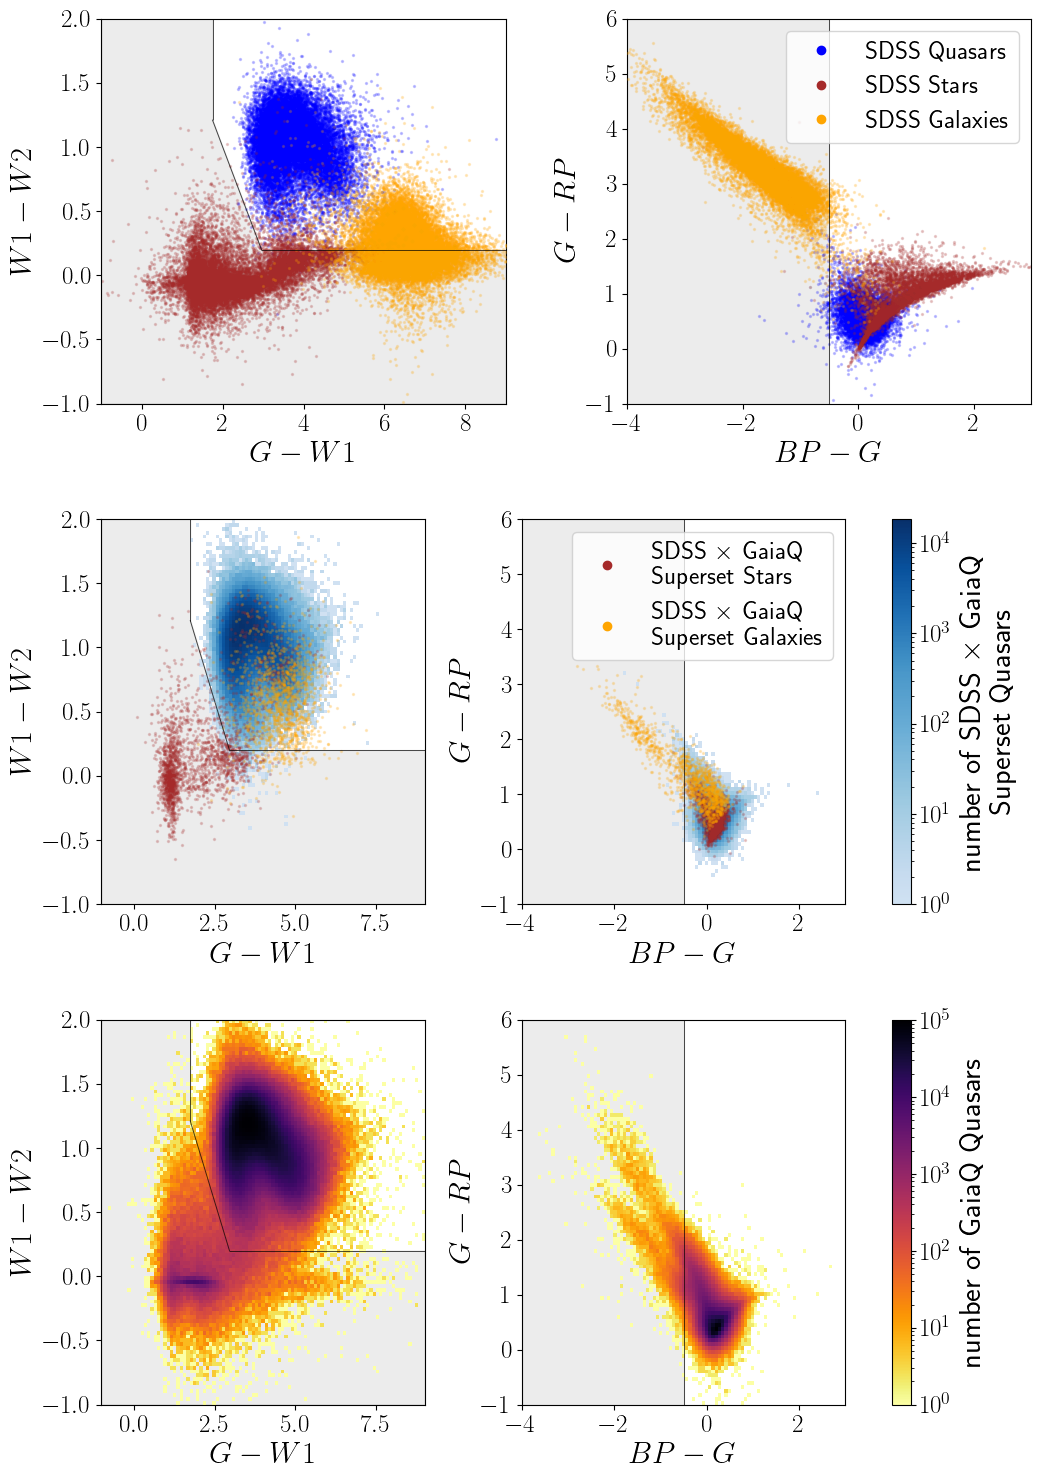

In [471]:
nrows = 3
fig, axarr = plt.subplots(nrows=nrows, ncols=2, figsize=(12,6*nrows))
plt.subplots_adjust(hspace=0.3, wspace=0.3)
color_color_plot_row(axarr[0,0], axarr[0,1], fig, tabs_scatter=tabs_sall, colors_scatter=colors_sall, 
                     labels_scatter=labels_sall, zorders_scatter=zorders_sall, N_subsample=20000)
color_color_plot_row(axarr[1,0], axarr[1,1], fig, tabs_scatter=tabs_ssup, colors_scatter=colors_ssup, 
                     labels_scatter=labels_ssup, zorders_scatter=zorders_ssup,
                     tab_hist=tab_q, cmap_hist=cmap_blues, label_hist=label_shist, cmax_hist=5e4)
color_color_plot_row(axarr[2,0], axarr[2,1], fig,
                     tab_hist=tab_gsup, cmap_hist=cmap_hist, label_hist=label_ghist, cmax_hist=2e5)

TODO: light grey transparent background where excluding

## Redshift analysis vs SDSS

In [37]:
redshift_estimator_name = 'kNN'
save_tag_model = f'_K27_std'
fn_spz_labeled = f'../data/redshift_estimates/redshifts_spz_labeled_{redshift_estimator_name}{save_tag_model}.fits'
tab_spz_labeled = utils.load_table(fn_spz_labeled)
print(f"N = {len(tab_spz_labeled)}")
print(tab_spz_labeled.columns)

N = 245308
<TableColumns names=('source_id','z_sdss','phot_g_mean_mag','redshift_qsoc','rand_ints','redshift_spz_raw','redshift_spz_err','redshift_spz')>


TODO: Should i show these for all labeled and not just test? Looks much nicer when i do, but not entirely fair to include training set

In [38]:
rand_ints_labeled = tab_spz_labeled['rand_ints']
i_train, i_valid, i_test = utils.split_train_val_test(rand_ints_labeled,
                                 frac_train=0.7, frac_val=0.15, frac_test=0.15)

In [39]:
idx_Glo_test = tab_spz_labeled['phot_g_mean_mag'][i_test] < G_lo

In [40]:
idx_Ghi_test = tab_spz_labeled['phot_g_mean_mag'][i_test] < G_hi

### Redshift estimates vs SDSS accuracy

In [41]:
z_sdss_test = tab_spz_labeled['z_sdss'][i_test]
z_spzraw_test = tab_spz_labeled['redshift_spz_raw'][i_test]
z_spz_test = tab_spz_labeled['redshift_spz'][i_test]
z_gaia_test = tab_spz_labeled['redshift_qsoc'][i_test]

In [ ]:
dz_spzraw_test = (z_spzraw_test - z_sdss_test)/(1+z_sdss_test)
dz_spz_test = (z_spz_test - z_sdss_test)/(1+z_sdss_test)
dz_gaia_test = (z_gaia_test - z_sdss_test)/(1+z_sdss_test)

In [339]:
z_bins = np.linspace(0, np.max(z_gaia_test), 200)

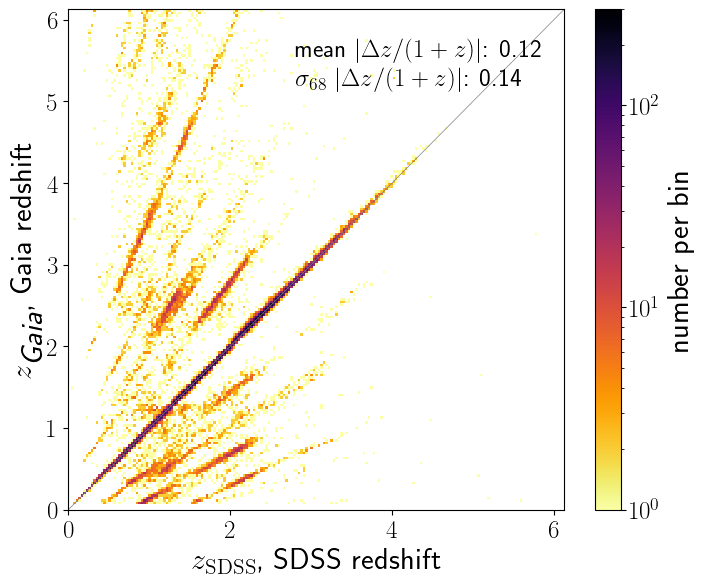

In [343]:
fig, ax = plt.subplots(1, 1, figsize = (8, 6.5))

h = ax.hist2d(z_sdss_test[idx_Ghi_test], z_gaia_test[idx_Ghi_test], bins=z_bins, cmin=1, cmap=cmap_hist,
              norm=matplotlib.colors.LogNorm(vmax=3e2),
              )
fig.colorbar(h[3], ax=ax, label='number per bin')
plt.plot(z_bins, z_bins, color='grey', lw=0.5)

# text
mean = np.mean(dz_gaia_test)
p16 = np.percentile(dz_gaia_test, 16)
p84 = np.percentile(dz_gaia_test, 84)
sigma = 0.5*(p84-p16)
text = rf'mean $|\Delta z/(1+z)|$: {mean:.2f}' + '\n' + \
       rf'$\sigma_{{68}}$ $|\Delta z/(1+z)|$: {sigma:.2f} '
plt.text(2.8, 5.2, text, fontsize=18)

plt.xlabel(r'$z_\mathrm{SDSS}$, SDSS redshift')
plt.ylabel(r'$z_\mathrm{\textit{Gaia}}$, Gaia redshift')

fn = f'{plot_dir}/redshift_zgaia_vs_zdss.png'
if save:
    plt.savefig(fn, bbox_inches='tight')

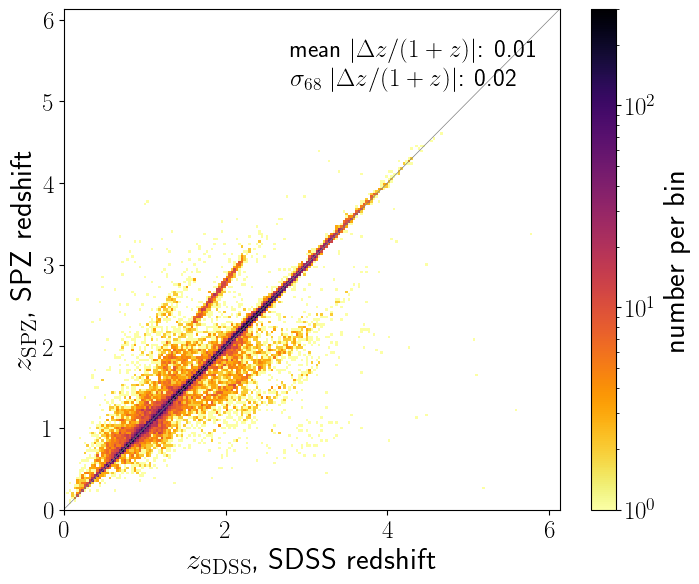

In [344]:
fig, ax = plt.subplots(1, 1, figsize = (8, 6.5))
h = ax.hist2d(z_sdss_test[idx_Ghi_test], z_spz_test[idx_Ghi_test], bins=z_bins, cmin=1, cmap=cmap_hist,
              norm=matplotlib.colors.LogNorm(vmax=3e2),
              )
fig.colorbar(h[3], ax=ax, label='number per bin')

plt.plot(z_bins, z_bins, color='grey', lw=0.5)

# text
mean = np.mean(dz_spz_test)
p16 = np.percentile(dz_spz_test, 16)
p84 = np.percentile(dz_spz_test, 84)
sigma = 0.5*(p84-p16)
text = rf'mean $|\Delta z/(1+z)|$: {mean:.2f}' + '\n' + \
       rf'$\sigma_{{68}}$ $|\Delta z/(1+z)|$: {sigma:.2f} '
plt.text(2.8, 5.2, text, fontsize=18)

plt.xlabel(r'$z_\mathrm{SDSS}$, SDSS redshift')
plt.ylabel(r'$z_\mathrm{SPZ}$, SPZ redshift')

fn = f'{plot_dir}/redshift_zspz_vs_zdss.png'
if save:
    plt.savefig(fn, bbox_inches='tight')

TODO: make cmin bigger and use extend feature, so low parts are more visible

### dz error cumulative histograms

In [46]:
dz_bins_log = np.logspace(-4, np.log10(2), 50)

TODO: it looks worse when we do the softening vs just the z=0.1 hard cut. better way to choose the min than im doing maybe?

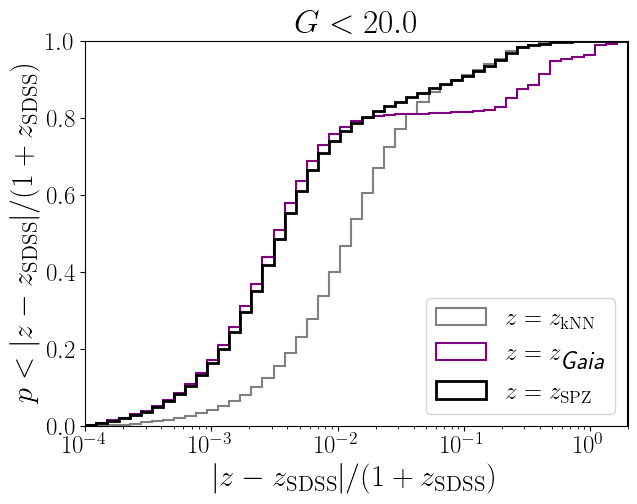

In [47]:
plt.figure(figsize=(7,5))
plt.title(rf'$G<{G_lo}$', fontsize=24)
lw=1.5
plt.hist(abs(dz_spzraw_test[idx_Glo_test]), bins=dz_bins_log, 
         histtype='step', cumulative=True, density=True, lw=lw,
         color='grey', label=r'$z=z_\mathrm{kNN}$')
plt.hist(abs(dz_gaia_test[idx_Glo_test]), bins=dz_bins_log, 
         histtype='step', cumulative=True, density=True, lw=lw,
         color='purple', label=r'$z=z_\mathrm{\emph{Gaia}}$')
plt.hist(abs(dz_spz_test[idx_Glo_test]), bins=dz_bins_log, 
         histtype='step', cumulative=True, density=True, lw=2,
         color='k', label=r'$z=z_\mathrm{SPZ}$')
plt.xlabel(r'$|z-z_\mathrm{SDSS}|/(1+z_\mathrm{SDSS})$')
plt.ylabel(r'$p < |z-z_\mathrm{SDSS}|/(1+z_\mathrm{SDSS})$')
plt.xscale('log')
plt.xlim(1e-4, 2)
plt.ylim(0,1)
plt.legend(loc='lower right')

fn = f'{plot_dir}/redshift_error_cumulative_Glo.png'
if save:
    plt.savefig(fn, bbox_inches='tight')

### Fraction of outliers as function of G

TODO why is this so different than earlier version??

[18.  18.1 18.2 18.3 18.4 18.5 18.6 18.7 18.8 18.9 19.  19.1 19.2 19.3
 19.4 19.5 19.6 19.7 19.8 19.9 20.  20.1 20.2 20.3 20.4 20.5]


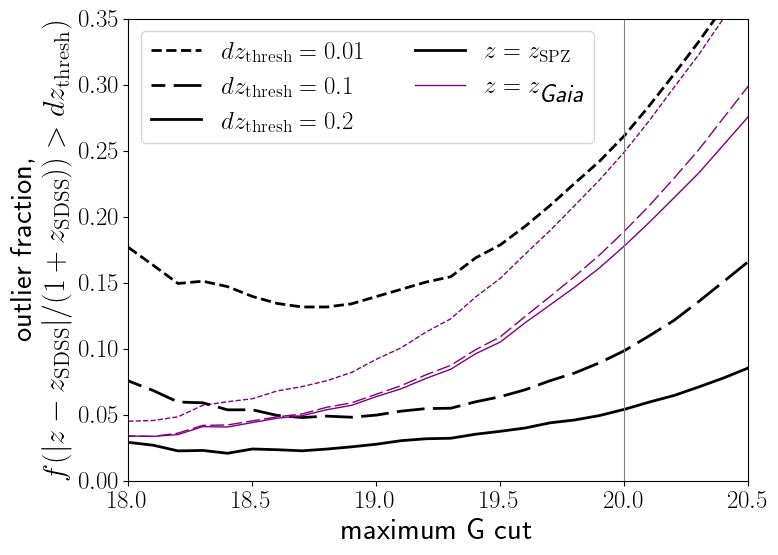

In [48]:
plt.figure(figsize=(8,6))
ax = plt.gca()

G_arr = tab_spz_labeled['phot_g_mean_mag'][i_test]
G_maxs = np.arange(18.0, 20.501, 0.1)
print(G_maxs)

dz_threshs = [0.01, 0.1, 0.2]
alphas = [0.4, 0.6, 0.8, 1]
lss = ['--', (5, (10,3)), '-']
for iz, dz_thresh in enumerate(dz_threshs):
    n_insample = np.empty(len(G_maxs), dtype=int)
    f_outliers_spz = np.empty(len(G_maxs))
    f_outliers_gaia = np.empty(len(G_maxs))

    for i in range(len(G_maxs)):
        i_insample = G_arr < G_maxs[i]
        n_insample[i] = np.sum(i_insample)
        
        f_outliers_spz[i] = np.sum(np.abs(dz_spz_test[i_insample]) > dz_thresh) / n_insample[i]
        f_outliers_gaia[i] = np.sum(np.abs(dz_gaia_test[i_insample]) > dz_thresh) / n_insample[i]
        
    plt.plot(G_maxs, f_outliers_spz, color='k', alpha=1, ls=lss[iz], lw=2, label=fr'$dz_\mathrm{{thresh}}={dz_thresh}$')
    plt.plot(G_maxs, f_outliers_gaia, color=color_gaia, alpha=1, ls=lss[iz], lw=1)

plt.xlabel("maximum G cut")
plt.ylabel('outlier fraction,\n' + r'$f(|z-z_\mathrm{SDSS}|/(1+z_\mathrm{SDSS}))>dz_\mathrm{{thresh}})$')
plt.ylim(0, 0.35)
plt.xlim(np.min(G_maxs), np.max(G_maxs))


handles, labels = ax.get_legend_handles_labels()
line_spz = Line2D([], [], color='k', lw=2)#, label='$z=z_\mathrm{SPZ/QSOC}$')
line_gaia = Line2D([], [], color=color_gaia, lw=1)#, label='$z=z_\mathrm{QSOC}$')
handles.extend([line_spz, line_gaia])
labels.extend(['$z=z_\mathrm{SPZ}$', '$z=z_\mathrm{\emph{Gaia}}$'])

plt.legend(handles, labels, ncol=2)

plt.axvline(20.0, color='grey', lw=0.8)

fn = f'{plot_dir}/redshift_outliers_vs_Gmax.png'
if save:
    plt.savefig(fn, bbox_inches='tight')

### Selection function systematics maps

In [49]:
NSIDE = 64
NPIX = hp.nside2npix(NSIDE)
print(NSIDE, NPIX)
area_per_pixel = hp.nside2pixarea(NSIDE, degrees=True)
print(f"Area per pixel: {area_per_pixel:.3f} deg")

64 49152
Area per pixel: 0.839 deg


In [50]:
fn_dustmap = f'../data/maps/map_dust_NSIDE{NSIDE}.npy'
map_dust = maps.get_dust_map(NSIDE=NSIDE, R=3.1, fn_map=fn_dustmap)

Dustmap already exists, loading from ../data/maps/map_dust_NSIDE64.npy


In [51]:
fn_starmap = f'../data/maps/map_stars_NSIDE{NSIDE}.npy'
map_stars = maps.get_star_map(NSIDE=NSIDE, fn_map=fn_starmap)
map_stardens = map_stars/area_per_pixel

Star map already exists, loading from ../data/maps/map_stars_NSIDE64.npy


In [52]:
fn_m10map = f'../data/maps/map_m10_NSIDE{NSIDE}.npy'
map_m10 = maps.get_m10_map(NSIDE=NSIDE, fn_map=fn_m10map)

M10 map already exists, loading from ../data/maps/map_m10_NSIDE64.npy


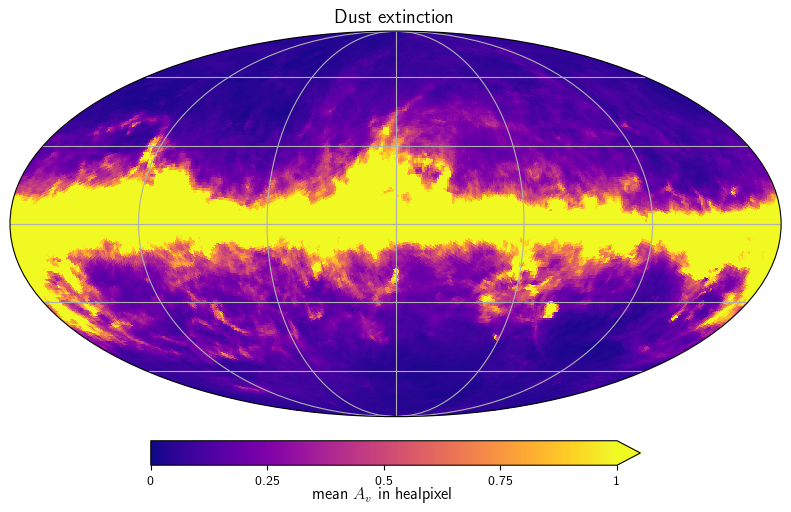

In [53]:
projview(map_dust, title=rf"Dust extinction",
         unit=r"mean $A_v$ in healpixel", cmap=cmap_map, coord=['C', 'G'], 
         min=0.0, max=1.0, cbar_ticks=[0, 0.25, 0.5, 0.75, 1.0],
         graticule=True)

fn = f'{plot_dir}/systematics_map_dust.png'
if save:
    plt.savefig(fn, bbox_inches='tight')

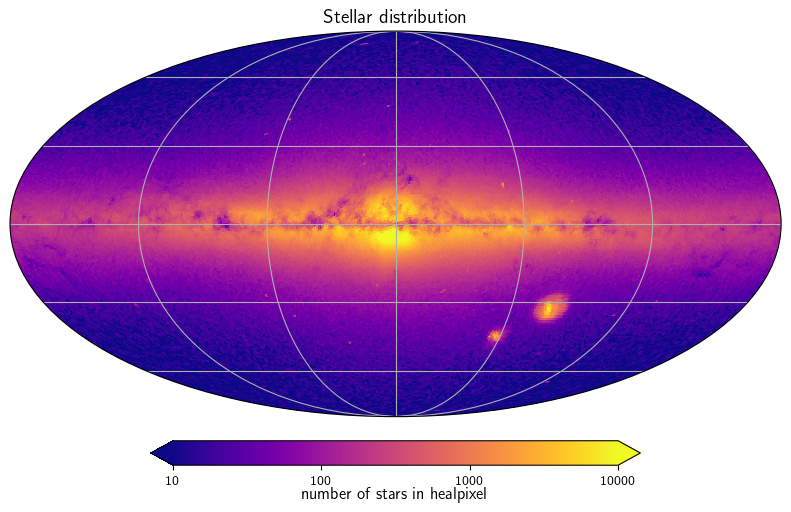

In [54]:
projview(map_stars, title=rf"Stellar distribution",
         unit=r"number of stars in healpixel", cmap=cmap_map, coord=['C', 'G'], 
         min=10, max=10000, norm='log', cbar_ticks=[10, 100, 1000, 10000],
         graticule=True)

fn = f'{plot_dir}/systematics_map_stars.png'
if save:
    plt.savefig(fn, bbox_inches='tight')

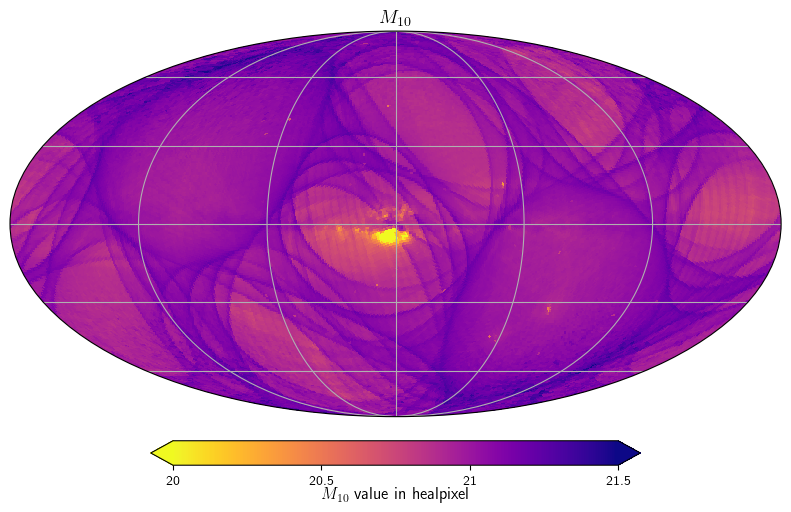

In [55]:
# reverse colormap bc high is worse here
projview(map_m10, title=r"$M_{10}$",
         unit=r"$M_{10}$ value in healpixel", cmap=cmap_map+'_r', coord=['C', 'G'],
         min=20.0, max=21.5, cbar_ticks=[20.0, 20.5, 21.0, 21.5],
         graticule=True)

fn = f'{plot_dir}/systematics_map_m10.png'
if save:
    plt.savefig(fn, bbox_inches='tight')

In [361]:
from gaiaunlimited.selectionfunctions import DR3SelectionFunctionTCG_hpx7 
dr3sf = DR3SelectionFunctionTCG_hpx7()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/ksf/.gaiaunlimited/allsky_M10_hpx7.hdf5'

# Catalog properties

### Sky distribution

In [347]:
map_gcatlo = get_ndens_map(tab_gcatlo['ra'], tab_gcatlo['dec'])

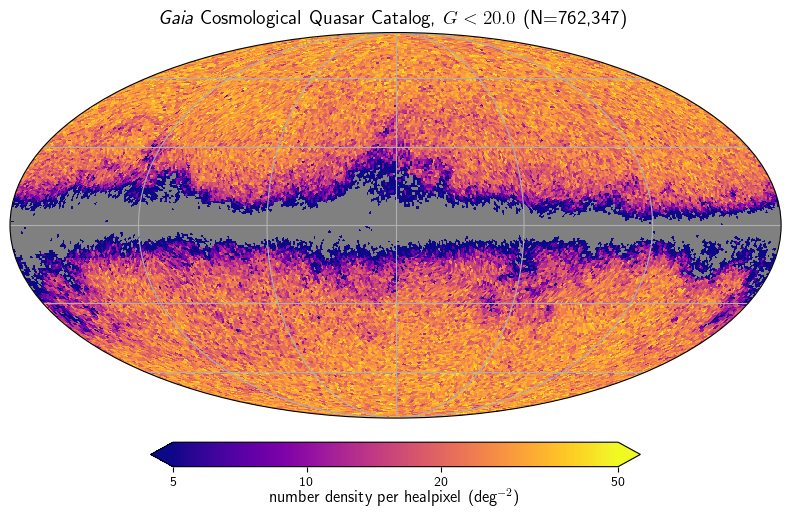

In [348]:
title_gcatlo = rf"{name_catalog}, $G<{G_lo}$ (N={len(tab_gcatlo):,})"
projview(map_gcatlo, title=title_gcatlo,
            unit=r"number density per healpixel (deg$^{-2}$)", cmap=cmap_map, coord=['C', 'G'], 
            min=5, max=50, norm='log', graticule=True,
            cbar_ticks=[5, 10, 20, 50])

fn = f'{plot_dir}/gcatlo_2d.png'
if save:
    plt.savefig(fn, bbox_inches='tight')

In [349]:
map_gcathi = get_ndens_map(tab_gcathi['ra'], tab_gcathi['dec'])

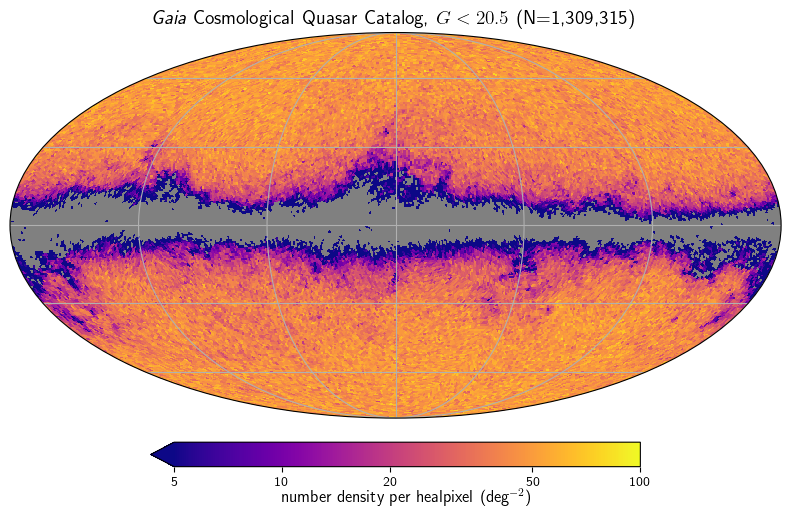

In [350]:
title_gcathi = rf"{name_catalog}, $G<{G_hi}$ (N={len(tab_gcathi):,})"
projview(map_gcathi, title=title_gcathi,
            unit=r"number density per healpixel (deg$^{-2}$)", cmap=cmap_map, coord=['C', 'G'], 
            min=5, max=100, norm='log', graticule=True,
            cbar_ticks=[5, 10, 20, 50, 100])

fn = f'{plot_dir}/gcathi_2d.png'
if save:
    plt.savefig(fn, bbox_inches='tight')

TODO: see if can kill mcs with color or something; if not, cover w little circle masks

### Redshift distribution

GaiaQ, $z_\mathrm{SPZ}$
1318566
767866
1.446
GaiaQ, $z_\mathrm{\emph{Gaia}}$
1318566
767866
1.550
\emph{Gaia} candidates, $z_\mathrm{QSOC}$
6649162
1713913


/Users/ksf/miniconda3/envs/gaiaenv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


1.553
\emph{Gaia} purer, $z_\mathrm{QSOC}$
1942825
778054
1.550
SDSS Quasars $\times$ GaiaQ, $z_\mathrm{SDSS}$
245308
125539
1.721


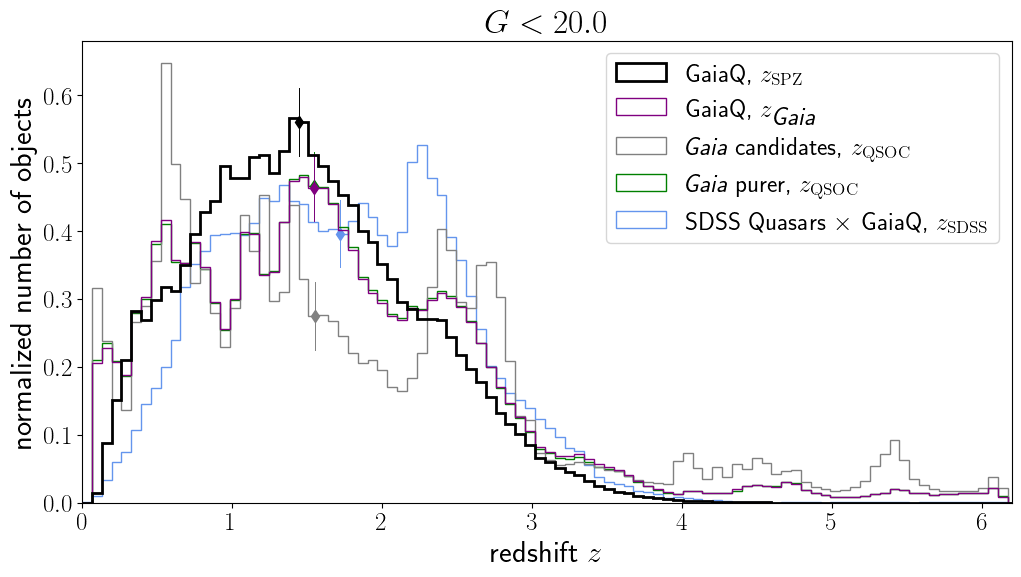

In [60]:
alpha = 1
density = True
histtype='step'
z_bins = np.linspace(0,6.5,100)

tabs_znames = [(tab_gcathi, 'redshift_spz'),
              (tab_gcathi, 'redshift_qsoc'),
              (tab_gall, 'redshift_qsoc'),
              (tab_gpurer, 'redshift_qsoc'),
              (tab_spz_labeled, 'z_sdss')
             ]

labels = [r'GaiaQ, $z_\mathrm{SPZ}$',
          r'GaiaQ, $z_\mathrm{\emph{Gaia}}$',
          r'\emph{Gaia} candidates, $z_\mathrm{\emph{Gaia}}$',
          r'\emph{Gaia} purer, $z_\mathrm{\emph{Gaia}}$',
          r'SDSS Quasars $\times$ GaiaQ, $z_\mathrm{SDSS}$'
         ]

colors = ['black', color_gaia, 'grey', 'green', 'cornflowerblue']
lws = [2, 1, 1, 1, 1]
zorders = [5,4,3,2,1]

plt.figure(figsize=(12,6))
plt.title(rf"$G < {G_lo}$")

lw_med = 0.7
for ii in range(len(tabs_znames)):
    print(labels[ii])
    tab, z_name = tabs_znames[ii]
    print(len(tab))
    i_G = tab['phot_g_mean_mag'] < G_lo

    z_data = tab[i_G][z_name]
    i_finite = np.isfinite(z_data)
    z_data = z_data[i_finite]
    print(len(z_data))

    ns, bs, _ = plt.hist(z_data, bins=z_bins, alpha=alpha, color=colors[ii], lw=lws[ii], 
                 density=density, histtype=histtype, label=labels[ii], zorder=zorders[ii])
    
    z_med = np.median(z_data)
    # figure out where to plot median
    bb = np.digitize(z_med, bs)
    nval = ns[bb-1]
    plt.plot([z_med]*2, [nval-0.05, nval+0.05], lw=lw_med, color=colors[ii], zorder=zorders[ii])
    plt.plot(z_med, nval, marker='d', color=colors[ii], zorder=zorders[ii])
    print(f'{z_med:.3f}')

plt.xlabel(r'redshift $z$')
plt.ylabel('normalized number of objects')
plt.legend()

plt.xlim(0,6.2)

fn = f'{plot_dir}/redshift_dists_Glo.png'
if save:
    plt.savefig(fn, bbox_inches='tight')

TODO: does it makes sense that gaia purer and gaiaq qsoc redshifts are essentially the same?

A: discuss in paper; also about sdss dist being imprinted onto ours

### G distribution

GaiaQ, $G<20.5$
\emph{Gaia} candidates
\emph{Gaia} purer
SDSS Quasars $\times$ GaiaQ


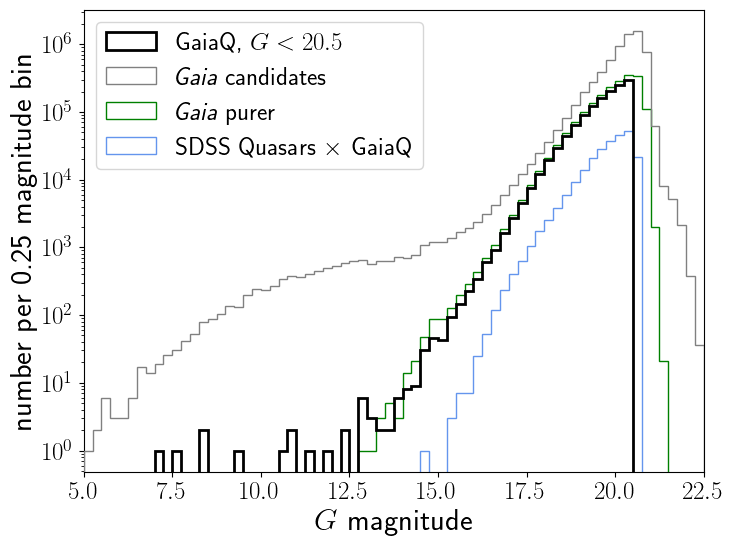

In [61]:
xlim = 5, 22.5
bin_width = 0.25
G_bins = np.arange(xlim[0], xlim[1]+bin_width, bin_width)

alpha = 1
density = False
histtype='step'

tabs = [tab_gcathi,
        tab_gall,
        tab_gpurer,
        tab_spz_labeled,
        ]

labels = [rf'GaiaQ, $G<{G_hi}$',
          r'\emph{Gaia} candidates',
          r'\emph{Gaia} purer',
          r'SDSS Quasars $\times$ GaiaQ'
         ]

colors = ['black', 'grey', 'green', 'cornflowerblue']
lws = [2, 1, 1, 1, 1]
zorders = [5,4,3,2,1]

plt.figure(figsize=(8,6))

lw_med = 0.7
for ii in range(len(tabs)):
    print(labels[ii])
    G_data = tabs[ii]['phot_g_mean_mag'] 
    i_finite = np.isfinite(G_data)
    G_data = G_data[i_finite]

    plt.hist(G_data, bins=G_bins, alpha=alpha, color=colors[ii], lw=lws[ii], 
                 density=density, histtype=histtype, label=labels[ii], zorder=zorders[ii])
    
plt.yscale('log')
plt.xlabel(r'$G$ magnitude')
plt.ylabel(f'number per {bin_width} magnitude bin')
plt.legend()

plt.xlim(xlim)

fn = f'{plot_dir}/G_dist.png'
if save:
    plt.savefig(fn, bbox_inches='tight')

TODO: should the Gaia in GaiaQ be italicized?

TODO: should i keep sdss quasars on here? and should it be the intersection?

### Selection function map

TODO: update selection function map!

In [351]:
fn_sel = f"../data/maps/mapQ_probability_dust_stars_m10_NSIDE{NSIDE}_G{G_lo}.fits"
map_sel = hp.read_map(fn_sel)

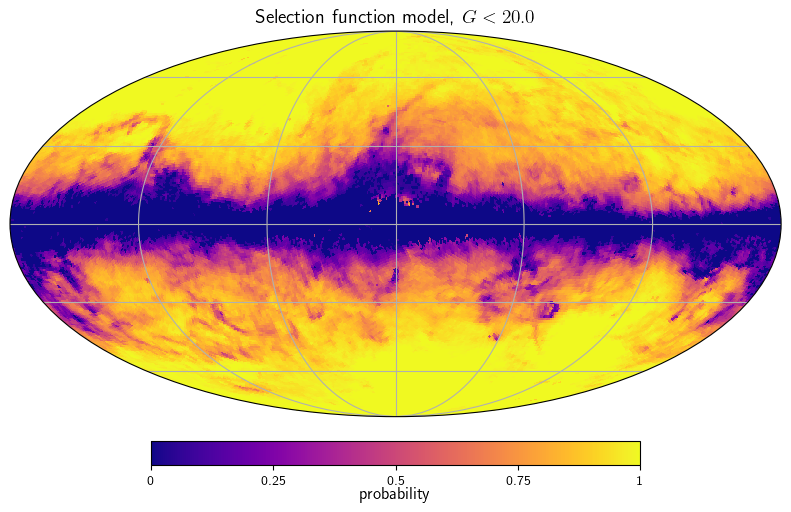

In [352]:
projview(map_sel, title=rf"Selection function model, $G<{G_lo}$",
            unit=r"probability", cmap=cmap_map, coord=['C', 'G'], 
            graticule=True, min=0, max=1, cbar_ticks=[0, 0.25, 0.5, 0.75, 1.0],
            ) 

fn = f'{plot_dir}/selection_function_Glo.png'
if save:
    plt.savefig(fn, bbox_inches='tight')

In [353]:
fn_sel = f"../data/maps/mapQ_probability_dust_stars_m10_NSIDE{NSIDE}_G{G_hi}.fits"
map_sel = hp.read_map(fn_sel)

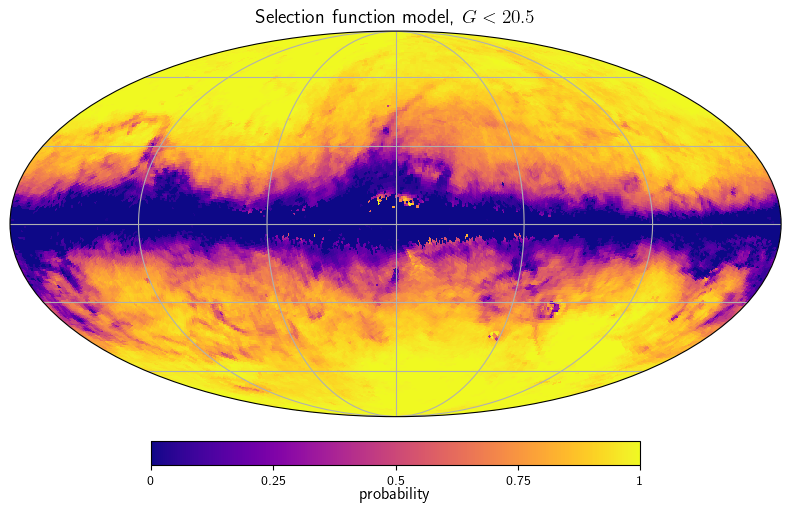

In [354]:
projview(map_sel, title=rf"Selection function model, $G<{G_hi}$",
            unit=r"probability", cmap=cmap_map, coord=['C', 'G'], 
            graticule=True, min=0, max=1, cbar_ticks=[0, 0.25, 0.5, 0.75, 1.0],
            ) 

fn = f'{plot_dir}/selection_function_Ghi.png'
if save:
    plt.savefig(fn, bbox_inches='tight')

TODO: try sel func fitting while masking MCs

### Random catalog & residuals

In [355]:
fn_rand_Glo = f'../data/randoms/randomQ_stardustm10_NSIDE64_G{G_lo}_10x.fits'
tab_rand_Glo = Table.read(fn_rand_Glo)
print(f"Number of random sources: {len(tab_rand_Glo)}")

Number of random sources: 7645000


In [356]:
map_rand_Glo = get_ndens_map(tab_rand_Glo['ra'], tab_rand_Glo['dec'])

Currently don't have random plot in the paper, just the residuals, but plot here as check

/Users/ksf/miniconda3/envs/gaiaenv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


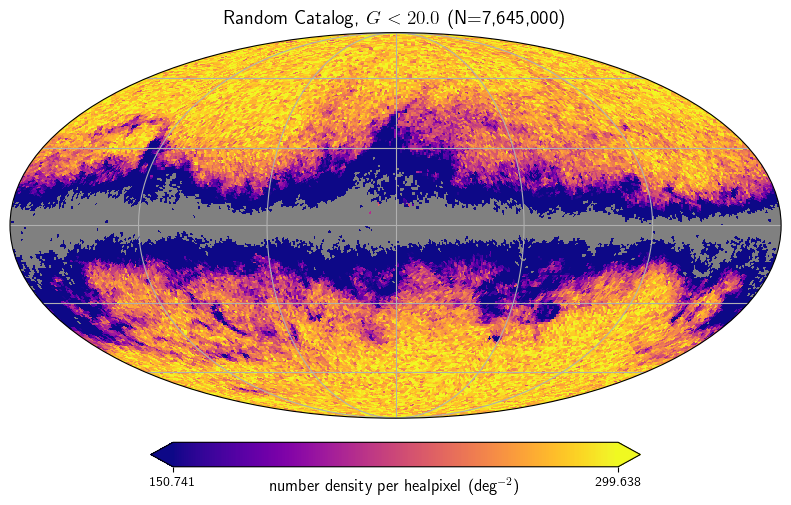

In [357]:
projview(map_rand_Glo, title=rf"Random Catalog, $G<{G_lo}$ (N={len(tab_rand_Glo):,})",
            unit=r"number density per healpixel (deg$^{-2}$)", cmap=cmap_map, coord=['C', 'G'], 
            min=np.median(map_rand_Glo)-np.std(map_rand_Glo), max=np.median(map_rand_Glo)+np.std(map_rand_Glo), 
            norm='log', graticule=True,
            #show_tickmarkers=True
        )#, cbar_ticks=[5, 10, 20, 50, 100, 500, 1000]) 

Not totally clear what masking here is doing when subtract

Should show fractional? Not fair by plane, but fairer elsewhere?

In [358]:
norm_factor = len(tab_gcatlo)/len(tab_rand_Glo)
map_residuals_Glo = norm_factor*map_rand_Glo/map_gcatlo - 1

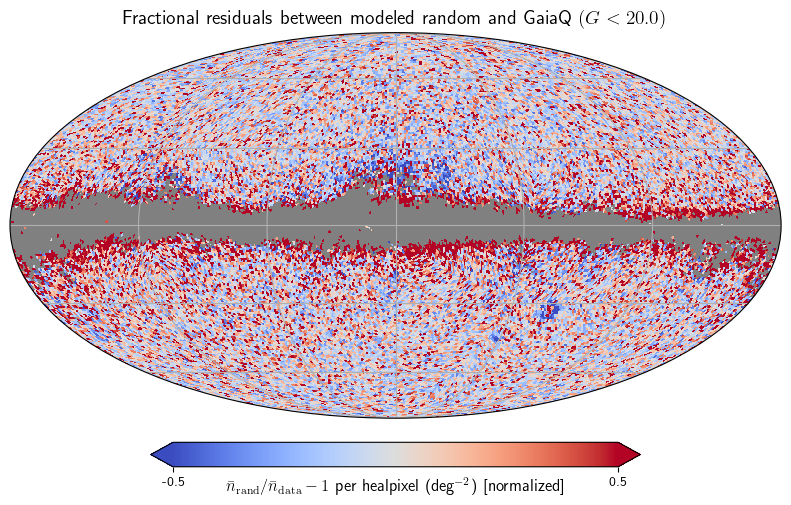

In [359]:
projview(map_residuals_Glo, title=rf"Fractional residuals between modeled random and {abbrv_catalog} $(G<{G_lo})$",
            unit=r"$\bar{n}_\mathrm{rand}/\bar{n}_\mathrm{data}-1$ per healpixel (deg$^{-2}$) [normalized]", cmap='coolwarm', coord=['C', 'G'], 
            min=-0.5, max=0.5, 
            graticule=True,
            #show_tickmarkers=True
            )#cbar_ticks=[5, 10, 20, 50, 100, 500, 1000]) 

fn = f'{plot_dir}/residuals_Glo.png'
if save:
    plt.savefig(fn, bbox_inches='tight')

### Checking out low-NSIDE map to try to see dipole

In [94]:
map_rand_Glo_NSIDEsmall = get_ndens_map(tab_rand_Glo['ra'], tab_rand_Glo['dec'], NSIDE=4)

In [95]:
map_gcatlo_NSIDEsmall = get_ndens_map(tab_gcatlo['ra'], tab_gcatlo['dec'], NSIDE=4)

In [96]:
norm_factor = len(tab_gcatlo)/len(tab_rand_Glo)
map_residuals_Glo_NSIDEsmall = 1/norm_factor*map_gcatlo_NSIDEsmall/map_rand_Glo_NSIDEsmall - 1

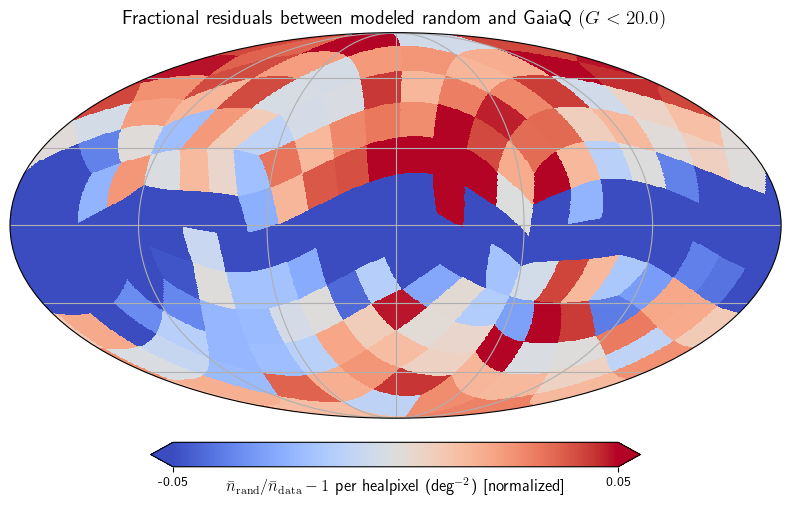

In [104]:
projview(map_residuals_Glo_NSIDEsmall, title=rf"Fractional residuals between modeled random and {abbrv_catalog} $(G<{G_lo})$",
            unit=r"$\bar{n}_\mathrm{rand}/\bar{n}_\mathrm{data}-1$ per healpixel (deg$^{-2}$) [normalized]", cmap='coolwarm', coord=['C', 'G'], 
            min=-0.05, max=0.05, 
            graticule=True,
            #alpha=(0.5 + 0*map_residuals_Glo_NSIDEsmall)
            #show_tickmarkers=True
            )#cbar_ticks=[5, 10, 20, 50, 100, 500, 1000]) 

### Animation snapshot

In [305]:
lim = 3500
vmin, vmax = 0, 4.5

In [282]:
tab_gcathi_anim = animate.prepare_data(tab_gcathi, 'redshift_spz')

Converting to cartesian


ValueError: Cannot replace column 'distance'.  Use Table.replace_column() instead.

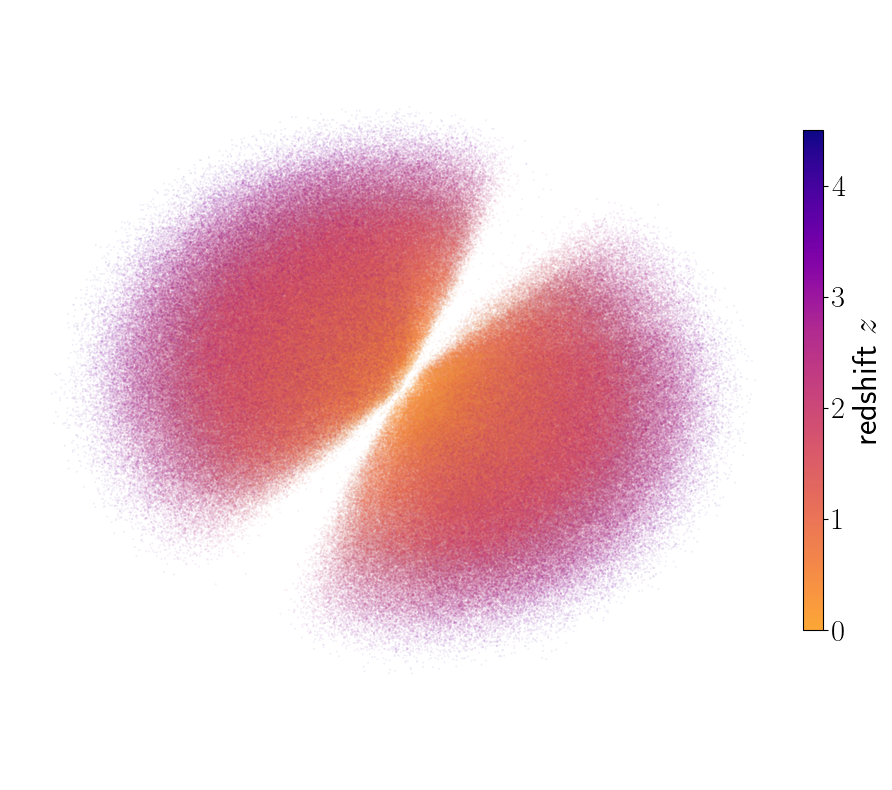

In [307]:
property_colorby = 'redshift_spz'

s = 0.11
alpha = 0.1
colorbar_label = r'redshift $z$'

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
animate.init_animation(fig, ax, tab_gcathi_anim, tab_gcathi_anim[property_colorby], 
                       s, alpha, lim, vmin, vmax,
                       cmap=cmap_anim, colorbar_label=colorbar_label)

fn = f'{plot_dir}/gcathi_3d.png'
if save:
    plt.savefig(fn, bbox_inches='tight')

In [296]:
fn_sdss = '../data/SDSS_DR16Q_v4.fits'
tab_sdss_all = utils.load_table(fn_sdss)
print(len(tab_sdss_all))

750414


In [297]:
i_zwarning0 = tab_sdss_all['ZWARNING']==0
i_zgood = tab_sdss_all['Z'] > 0.01
tab_sdss_all = tab_sdss_all[i_zwarning0 & i_zgood]
print(len(tab_sdss_all))

638016


In [298]:
tab_sdss_anim = animate.prepare_data(tab_sdss_all, 'Z', ra_name='RA', dec_name='DEC')

Converting to cartesian
Adding properties


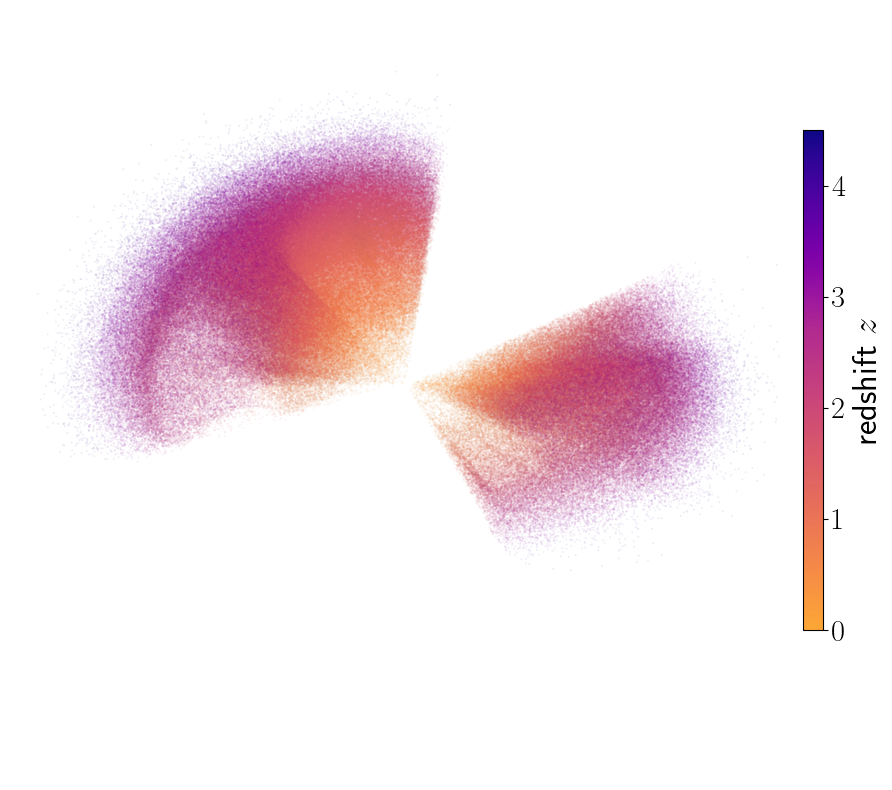

In [306]:
property_colorby = 'Z'

s = 0.11
alpha = 0.1
colorbar_label = r'redshift $z$'

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
animate.init_animation(fig, ax, tab_sdss_anim, tab_sdss_anim[property_colorby], 
                       s, alpha, lim, vmin, vmax,
                       cmap=cmap_anim, colorbar_label=colorbar_label)

fn = f'{plot_dir}/sdss_3d.png'
if save:
    plt.savefig(fn, bbox_inches='tight')

### Name ideas

In [209]:
# GWuasar
# GUNwise Quasars
# Gaia Quasmology (Quasmo)
# GCQC
# GWQC

# vol, z, bright, wise, gaia

# G'NUFF quasars
# Good&wise 
# Quaia
# Guys
# Guise
# Gise
# wise-guys quasar skies